In [9]:
import os

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import shapely.geometry
from scipy.misc import imresize
import pickle

%matplotlib inline

In [ ]:
with open('mn_xtrain_256_8channel_man.pkl', 'rb') as f:
    X_train_unet = pickle.load(f)

In [ ]:
with open('mn_ytrain_256_man.pkl', 'rb') as f:
    Y_train = pickle.load(f)

In [ ]:
with open('mn_xval_256_8channel_man.pkl', 'rb') as f:
    X_val_unet = pickle.load(f)

In [ ]:
with open('mn_yval_256_man.pkl', 'rb') as f:
    Y_val = pickle.load(f)

In [13]:
# Load the image summary
image_summary = gpd.read_file('vectors/shanghai_image_summary.geojson')

# Load the landuse data from OSM
osm_landuse = gpd.read_file('vectors/shanghai_landuse.geojson')

# Convert everything to polygons
osm_landuse.set_geometry(osm_landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)

# Limit to just farmland
farmland = osm_landuse[osm_landuse.landuse == 'farmland'].unary_union

# Background
farmyard = osm_landuse[osm_landuse.landuse == 'farmyard'].unary_union

vectors = [farmland]

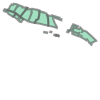

In [17]:
farmland

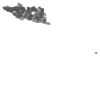

In [19]:
farmyard

In [15]:
INPUT_SIZE = 256

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []
    
def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def scale_bands(img, lower_pct=1, upper_pct=99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

def resize(img, new_shape):
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized



In [30]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

import keras
from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import Adam

# Set network size params
N_CLASSES = 1
N_CHANNEL = 8
INPUT_SIZE = 256
#IMG_DIM = 640

# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return - dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

K.clear_session()

def get_unet(lr=0.001):
    K.clear_session()
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef])
    
    return model

In [ ]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

NUM_EPOCHS = 75

# Define callback to save model checkpoints
if not os.path.exists('checkpoints_unet1_man'):
    os.makedirs('checkpoints_unet1_man')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints_unet1_man', 'weights.{epoch:02d}-{val_loss:.5f}.hdf5'),
                                  monitor='loss', save_best_only=True)

# Define callback to reduce learning rate when learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, epsilon=0.0001, cooldown=1)

# TensorBoard visualization
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs2', histogram_freq=0, write_graph=True, write_images=True)

csv_logger = CSVLogger('log.csv', separator=',', append=True)

# Train the model
model = get_unet(0.0001)
model.fit(X_train, Y_train, batch_size=12, epochs=NUM_EPOCHS, verbose=1, shuffle=True,
         callbacks=[model_checkpoint, tensorboard], validation_data=(X_val, Y_val))

Train on 3622 samples, validate on 517 samples
Epoch 1/75
3622/3622 [==============================] - 221s - loss: 0.2402 - jacc_coef: 0.0364 - val_loss: 0.2113 - val_jacc_coef: 0.0366
Epoch 2/75
3622/3622 [==============================] - 221s - loss: 0.2088 - jacc_coef: 0.0397 - val_loss: 0.2079 - val_jacc_coef: 0.0409
Epoch 3/75
3622/3622 [==============================] - 221s - loss: 0.2052 - jacc_coef: 0.0408 - val_loss: 0.2090 - val_jacc_coef: 0.0421
Epoch 4/75
3622/3622 [==============================] - 221s - loss: 0.2062 - jacc_coef: 0.0412 - val_loss: 0.2180 - val_jacc_coef: 0.0435
Epoch 5/75
3622/3622 [==============================] - 221s - loss: 0.2039 - jacc_coef: 0.0411 - val_loss: 0.2023 - val_jacc_coef: 0.0419
Epoch 6/75
3622/3622 [==============================] - 221s - loss: 0.2019 - jacc_coef: 0.0439 - val_loss: 0.1982 - val_jacc_coef: 0.0438
Epoch 7/75
3622/3622 [==============================] - 221s - loss: 0.1953 - jacc_coef: 0.0455 - val_loss: 0.1954 - va

KeyboardInterrupt: 

In [ ]:
# # If you need to load the model, you can use these lines.  Change the weights filename to match one you have.
# model = get_unet()
# model.load_weights('checkpoints/weights.50-0.08328.hdf5')

# Pick out which target to look at
CLASS_NO = 0

# Pick an image with some positive pixels in the target
usable_imgs = []
for i in range(Y_val.shape[0]):
    if Y_val[i, :, :, CLASS_NO].sum() > 1000:
        usable_imgs.append(i)
print("Found %d usable images in the validation set."%len(usable_imgs))
i = usable_imgs[22]
X = X_val[i]
Y = Y_val[i]

targ = Y[:, :, CLASS_NO]

# Run the model on that sample
pred = model.predict(X[None, ...])[0, :, :, CLASS_NO] > 0.15

# Plot it
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,8))
ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement
ax2.imshow(targ, vmin=0, vmax=1)
ax3.imshow(pred, vmin=0, vmax=1)

ax1.set_title('Image')
ax2.set_title('Ground Truth')
ax3.set_title('Prediction')

In [43]:
tensorboard.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 240, 240, 8)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 240, 240, 32)      2336      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 240, 240, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 120, 120, 32)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 120, 120, 64)      18496     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 120, 120, 64)      36928     
__________

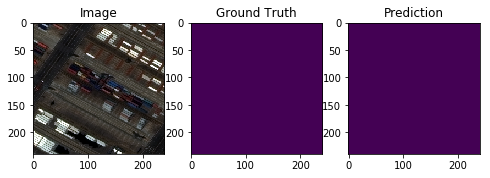

In [14]:
# # If you need to load the model, you can use these lines.
# model = get_unet()
# model.load_weights('checkpoints/weights.-0.57.hdf5')

# Pick an image with some positive pixels in the target
counter = 0
for i in range(Y_val.shape[0]):
    if Y_val[i].sum() > 5000:
        counter += 1
        if counter > 1:
            break
X = X_val[i]
Y = Y_val[i]

# Pick out which target to look at
CLASS_NO = 0
targ = Y[:, :, CLASS_NO]

# Run the model on that sample
pred = model.predict(X[None, ...])[0, :, :, CLASS_NO] > 0.15

# Plot it
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement
ax2.imshow(targ, vmin=0, vmax=1)
ax3.imshow(pred, vmin=0, vmax=1)

ax1.set_title('Image')
ax2.set_title('Ground Truth')
ax3.set_title('Prediction')